## Importing the necessary Libraries

In [102]:
import datetime
import os
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import tensorflow as tf 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,Dense,Dropout,BatchNormalization,Activation,Flatten,MaxPool2D
from tensorflow.keras.callbacks import EarlyStopping
from PIL import Image

In [2]:
device_name = tf.test.gpu_device_name()
if "GPU" not in device_name:
    print("No")
else:
    print(device_name)

/device:GPU:0


In [3]:
train_dataframe = pd.read_csv('C:/Users/pmals/Desktop/DSMLDLAI/German Traffic Sign Recognition/Train.csv')
train_dataframe.shape

(39209, 8)

In [4]:
train_dataframe.describe()

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId
count,39209.000000,39209.000000,39209.000000,39209.000000,39209.000000,39209.000000,39209.000000
mean,50.835880,50.328930,5.999515,5.962381,45.197302,44.728379,15.788390
std,24.306933,23.115423,1.475493,1.385440,23.060157,21.971145,12.013238
min,25.000000,25.000000,0.000000,5.000000,20.000000,20.000000,0.000000
25%,35.000000,35.000000,5.000000,5.000000,29.000000,30.000000,5.000000
50%,43.000000,43.000000,6.000000,6.000000,38.000000,38.000000,12.000000
75%,58.000000,58.000000,6.000000,6.000000,53.000000,52.000000,25.000000
max,243.000000,225.000000,20.000000,20.000000,223.000000,205.000000,42.000000


In [5]:
train_dataframe.head()

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path
0,27,26,5,5,22,20,20,Train/20/00020_00000_00000.png
1,28,27,5,6,23,22,20,Train/20/00020_00000_00001.png
2,29,26,6,5,24,21,20,Train/20/00020_00000_00002.png
3,28,27,5,6,23,22,20,Train/20/00020_00000_00003.png
4,28,26,5,5,23,21,20,Train/20/00020_00000_00004.png


### Making sure there are no null values

In [6]:
train_dataframe.isnull().sum()

Width      0
Height     0
Roi.X1     0
Roi.Y1     0
Roi.X2     0
Roi.Y2     0
ClassId    0
Path       0
dtype: int64

In [7]:
print("The total number of output categories are: ", len(train_dataframe['ClassId'].value_counts()))

The total number of output categories are:  43


<AxesSubplot:xlabel='ClassId', ylabel='count'>

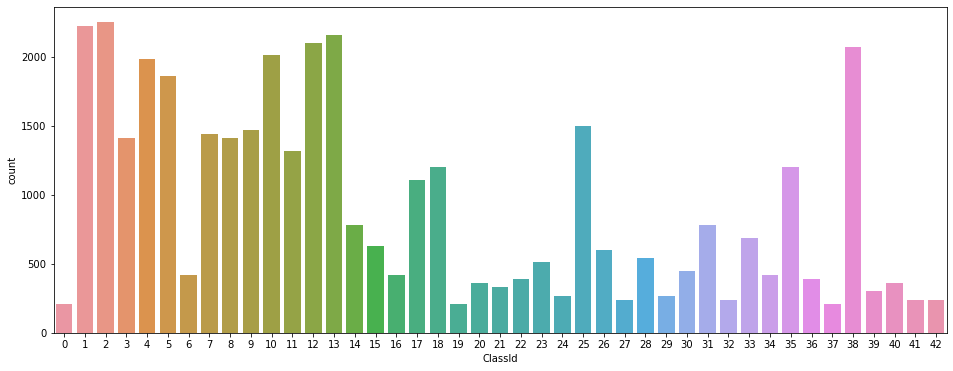

In [8]:
plt.figure(figsize=(16,6))
sns.countplot(x=train_dataframe['ClassId'])

#### Getting images and their labels

In [9]:
filenames = ['C:/Users/pmals/Desktop/DSMLDLAI/German Traffic Sign Recognition/' + i for i in train_dataframe['Path']]
filenames[:10]

['C:/Users/pmals/Desktop/DSMLDLAI/German Traffic Sign Recognition/Train/20/00020_00000_00000.png',
 'C:/Users/pmals/Desktop/DSMLDLAI/German Traffic Sign Recognition/Train/20/00020_00000_00001.png',
 'C:/Users/pmals/Desktop/DSMLDLAI/German Traffic Sign Recognition/Train/20/00020_00000_00002.png',
 'C:/Users/pmals/Desktop/DSMLDLAI/German Traffic Sign Recognition/Train/20/00020_00000_00003.png',
 'C:/Users/pmals/Desktop/DSMLDLAI/German Traffic Sign Recognition/Train/20/00020_00000_00004.png',
 'C:/Users/pmals/Desktop/DSMLDLAI/German Traffic Sign Recognition/Train/20/00020_00000_00005.png',
 'C:/Users/pmals/Desktop/DSMLDLAI/German Traffic Sign Recognition/Train/20/00020_00000_00006.png',
 'C:/Users/pmals/Desktop/DSMLDLAI/German Traffic Sign Recognition/Train/20/00020_00000_00007.png',
 'C:/Users/pmals/Desktop/DSMLDLAI/German Traffic Sign Recognition/Train/20/00020_00000_00008.png',
 'C:/Users/pmals/Desktop/DSMLDLAI/German Traffic Sign Recognition/Train/20/00020_00000_00009.png']

In [10]:
labels = train_dataframe['ClassId'].to_numpy()
labels

array([20, 20, 20, ..., 42, 42, 42], dtype=int64)

In [11]:
unique_signs = np.unique(labels)
len(unique_signs)

43

In [12]:
labels = tf.keras.utils.to_categorical(labels, 43)

In [13]:
X = filenames
y = labels

# Splitting our data into train and validation sets

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2, random_state = 42)
len(X_train), len(y_train), len(X_val), len(y_val)

(31367, 31367, 7842, 7842)

In [14]:
IMG_SIZE = 32

def process_image(image_path):
    """
    Takes an image file path and turns the image into a Tensor.
    """
    # Read in an image file
    image = tf.io.read_file(image_path)
    # Turn the jpeg/png image into numerical Tensor with 3 colour channels (Red, Green, Blue)
    image = tf.image.decode_png(image, channels=3)
    # Convert the colour channel values from 0-255 to 0-1 values
    image = tf.image.convert_image_dtype(image, tf.float32)
    # Resize the image to our desired value (32, 32)
    image = tf.image.resize(image, size=[IMG_SIZE, IMG_SIZE])
    return image


In [15]:
def get_image_label (image_path, label):
    """
    Takes an image file path name and the assosciated label,
    processes the image and reutrns a typle of (image, label).
    """
    image = process_image(image_path)
    return image, label

In [16]:
BATCH_SIZE = 64

# Create a function to turn data into batches
def create_data_batches (X, y=None, batch_size=BATCH_SIZE, valid_data=False, test_data=False):
    """
    Creates batches of data out of image (X) and label (y) pairs.
    Shuffles the data if it's training data but doesn't shuffle if it's validation dat
    a.
    Also accepts test data as input (no labels).
    """
    # If the data is a test dataset, we probably don't have have labels
    if test_data:
        print("Creating test data batches...")
        data = tf.data.Dataset.from_tensor_slices((tf.constant(X)))
        data_batch = data.map(process_image).batch(BATCH_SIZE)
    # If the data is a valid dataset, we don't need to shuffle it
    elif valid_data:
        print("Creating validation dataset batches...")
        data = tf.data.Dataset.from_tensor_slices((tf.constant(X), tf.constant(y)))
        # Create (image, label) tuples (this also turns the iamge path into a preprocessed image)
        data_batch = data.map(get_image_label).batch(BATCH_SIZE)
    else:
        print("Creating training dataset batches...")
        # Turn filepaths and labels into Tensors
        data = tf.data.Dataset.from_tensor_slices((tf.constant(X), tf.constant(y)))
        # Shuffling pathnames and labels before mapping image processor function is faster than shuffling images
        data = data.shuffle(buffer_size=len(X))
        # Create (image, label) tuples (this also turns the image path into a preprocessed image) and turning into batches
        data_batch = data.map(get_image_label).batch(BATCH_SIZE)
    return data_batch

In [17]:
train_data = create_data_batches(X_train, y_train)
val_data = create_data_batches(X_val, y_val, valid_data=True)

Creating training dataset batches...
Creating validation dataset batches...


In [18]:
# Check out the different attributes of our data batches
train_data.element_spec, val_data.element_spec

((TensorSpec(shape=(None, 32, 32, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 43), dtype=tf.float32, name=None)),
 (TensorSpec(shape=(None, 32, 32, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 43), dtype=tf.float32, name=None)))

In [19]:
# Create a function for viewing images in a data batch
def show_16_images (images, labels):
    """
    Displays a plot of 16 images and their labels from a data batch.
    """
    plt.figure(figsize=(10,10))
    for i in range(16):
        ax = plt.subplot(5, 5, i+1)
        plt.imshow(images[i])
        plt.title(unique_signs[labels[i].argmax()])
        plt.axis("off")

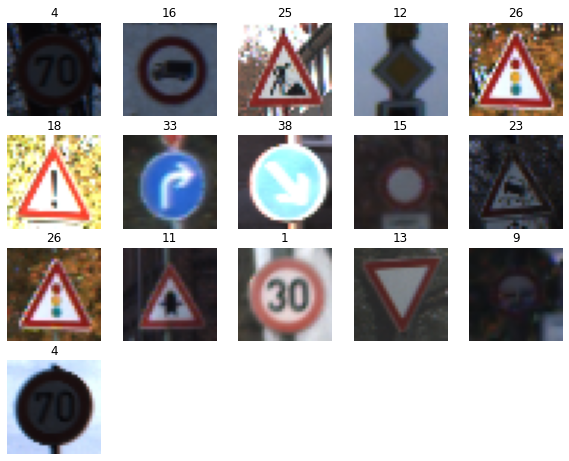

In [20]:
# Visualizing traing batch
train_images, train_labels = next(train_data.as_numpy_iterator())
show_16_images(train_images, train_labels)

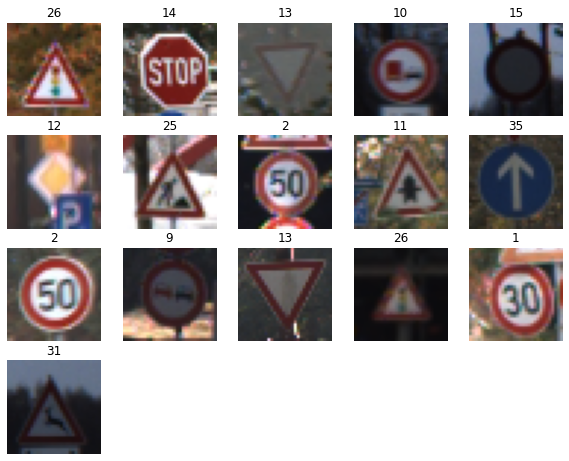

In [21]:
val_images, val_labels = next(val_data.as_numpy_iterator())
show_16_images(val_images, val_labels)

In [22]:
# Setup input shape to the model
INPUT_SHAPE = [IMG_SIZE, IMG_SIZE, 3]

# Setup the output shape
OUTPUT_SHAPE = len(unique_signs)

In [46]:
def traffic_sign_net(input_shape):
    model = Sequential()
    model.add(Conv2D(filters=32, kernel_size=(5, 5), activation='relu', input_shape=input_shape))
    model.add(Conv2D(filters=32, kernel_size=(5, 5), activation='relu'))
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(Dropout(rate=0.25))
    model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
    model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(Dropout(rate=0.25))
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(rate=0.5))
    model.add(Dense(43, activation='softmax'))
    return model

In [47]:
def create_model(input_shape=INPUT_SHAPE, output_shape=OUTPUT_SHAPE):
    # Setup the model layers
    model = traffic_sign_net(input_shape=input_shape)
    # Compile the model
    print("Compiling the model")
    model.compile(
        loss = tf.keras.losses.CategoricalCrossentropy(),
        optimizer = tf.keras.optimizers.Adam(),
        metrics = ["accuracy"]
    )
    return model

In [48]:
model = create_model()
model.summary()

Compiling the model
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 28, 28, 32)        2432      
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 24, 24, 32)        25632     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 12, 12, 32)        0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 10, 10, 64)        18496     
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 8, 8, 64)          36928     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None

In [49]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5)

In [50]:
NUM_EPOCHS = 50

In [51]:
def train_model():
    """
    Trains a given model and returns the trained version.
    """
    # Create a model
    model = create_model()
    # Fit the model to the data passing it the callbacks we created
    model.fit(x=train_data,
        epochs=NUM_EPOCHS,
        validation_data=val_data,
        validation_freq=1,
        callbacks=[early_stopping]
             )
    return model


In [52]:
# Fit the model to data
model = train_model()

Compiling the model
Epoch 1/50
491/491 [==============================] - 10s 19ms/step - loss: 1.6501 - accuracy: 0.5336 - val_loss: 0.3078 - val_accuracy: 0.9277
Epoch 2/50
491/491 [==============================] - 9s 18ms/step - loss: 0.2928 - accuracy: 0.9109 - val_loss: 0.0757 - val_accuracy: 0.9824
Epoch 3/50
491/491 [==============================] - 9s 19ms/step - loss: 0.1663 - accuracy: 0.9508 - val_loss: 0.0480 - val_accuracy: 0.9892
Epoch 4/50
491/491 [==============================] - 9s 18ms/step - loss: 0.1126 - accuracy: 0.9642 - val_loss: 0.0384 - val_accuracy: 0.9901
Epoch 5/50
491/491 [==============================] - 9s 18ms/step - loss: 0.0971 - accuracy: 0.9692 - val_loss: 0.0251 - val_accuracy: 0.9936
Epoch 6/50
491/491 [==============================] - 9s 18ms/step - loss: 0.0780 - accuracy: 0.9767 - val_loss: 0.0238 - val_accuracy: 0.9941
Epoch 7/50
491/491 [==============================] - 9s 18ms/step - loss: 0.0650 - accuracy: 0.9792 - val_loss: 0.0271 -

### Creating test dataset batches

In [53]:
test_df = pd.read_csv('C:/Users/pmals/Desktop/DSMLDLAI/German Traffic Sign Recognition/Test.csv')
test_df = test_df.drop(['Width', 'Height', 'Roi.X1', 'Roi.Y1', 'Roi.X2', 'Roi.Y2'], axis=1)
test_df.head()

,ClassId,Path
0,16,Test/00000.png
1,1,Test/00001.png
2,38,Test/00002.png
3,33,Test/00003.png
4,11,Test/00004.png


In [54]:
test_img_paths = ['C:/Users/pmals/Desktop/DSMLDLAI/German Traffic Sign Recognition/' + path for path in test_df['Path']]
test_img_paths[:10]

['C:/Users/pmals/Desktop/DSMLDLAI/German Traffic Sign Recognition/Test/00000.png',
 'C:/Users/pmals/Desktop/DSMLDLAI/German Traffic Sign Recognition/Test/00001.png',
 'C:/Users/pmals/Desktop/DSMLDLAI/German Traffic Sign Recognition/Test/00002.png',
 'C:/Users/pmals/Desktop/DSMLDLAI/German Traffic Sign Recognition/Test/00003.png',
 'C:/Users/pmals/Desktop/DSMLDLAI/German Traffic Sign Recognition/Test/00004.png',
 'C:/Users/pmals/Desktop/DSMLDLAI/German Traffic Sign Recognition/Test/00005.png',
 'C:/Users/pmals/Desktop/DSMLDLAI/German Traffic Sign Recognition/Test/00006.png',
 'C:/Users/pmals/Desktop/DSMLDLAI/German Traffic Sign Recognition/Test/00007.png',
 'C:/Users/pmals/Desktop/DSMLDLAI/German Traffic Sign Recognition/Test/00008.png',
 'C:/Users/pmals/Desktop/DSMLDLAI/German Traffic Sign Recognition/Test/00009.png']

In [55]:
X_test = create_data_batches(test_img_paths, test_data=True)
y_test = list(test_df['ClassId'])
y_test[:10]

Creating test data batches...


[16, 1, 38, 33, 11, 38, 18, 12, 25, 35]

In [56]:
predictions = model.predict(X_test, verbose=1)

198/198 [==============================] - 3s 14ms/step


In [57]:
def get_pred_label(prediction_probabilities):
    """
    Turns an array of prediction probabilities into a label.
    """
    return unique_signs[np.argmax(prediction_probabilities)]

In [58]:
# Turning probabilities to labels
pred_labels = []
for i in predictions:
    pred_labels.append(get_pred_label(i))
pred_labels[:10]

[16, 1, 38, 33, 11, 38, 18, 12, 25, 35]

In [59]:
# Getting the accuracy of the model on test data
acc = accuracy_score(y_test, pred_labels)
acc

0.976959619952494

In [60]:
from sklearn.metrics import confusion_matrix,classification_report

In [74]:
test_df['Predictions'] = pred_labels
test_df.head()

,ClassId,Path,Predictions
0,16,Test/00000.png,16
1,1,Test/00001.png,1
2,38,Test/00002.png,38
3,33,Test/00003.png,33
4,11,Test/00004.png,11


In [66]:
print(confusion_matrix(y_test, pred_labels))

[[ 60   0   0 ...   0   0   0]
 [  0 717   2 ...   0   0   0]
 [  0   1 746 ...   0   0   0]
 ...
 [  0   2   0 ...  86   0   0]
 [  0   0   0 ...   0  47   0]
 [  0   0   0 ...   0   0  89]]


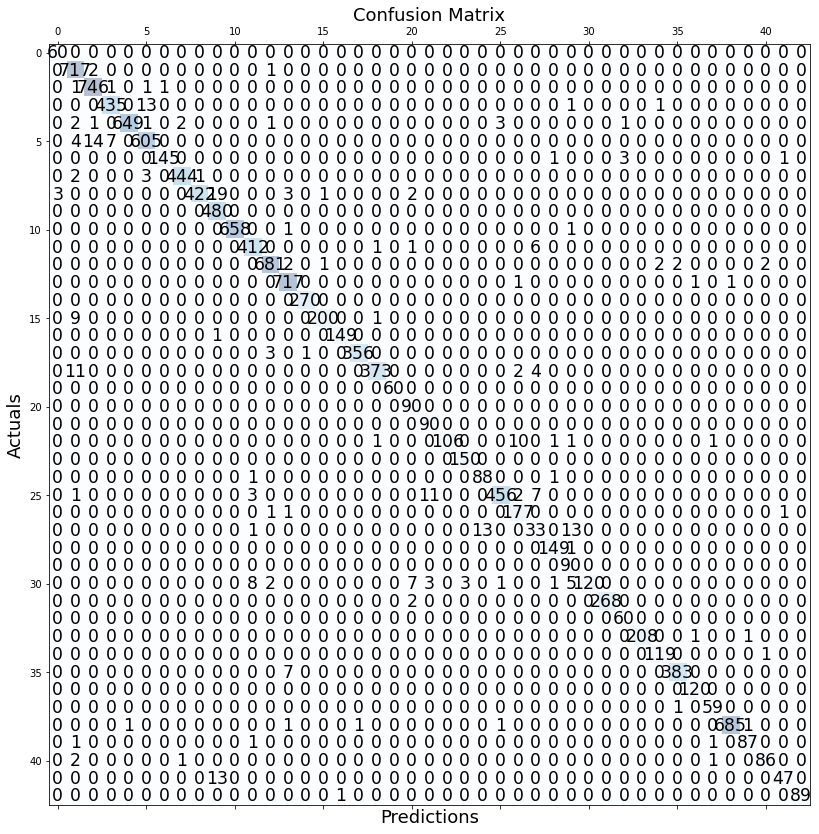

In [82]:
fig, ax = plt.subplots(figsize=(14, 14))
ax.matshow(confusion_matrix(y_test, pred_labels), cmap=plt.cm.Blues, alpha=0.3)
for i in range(confusion_matrix(y_test, pred_labels).shape[0]):
    for j in range(confusion_matrix(y_test, pred_labels).shape[1]):
        ax.text(x=j, y=i,s=confusion_matrix(y_test, pred_labels)[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

In [72]:
print(classification_report(test_df['ClassId'],test_df['Predictions']))

              precision    recall  f1-score   support

           0       0.95      1.00      0.98        60
           1       0.96      1.00      0.98       720
           2       0.98      0.99      0.99       750
           3       0.98      0.97      0.97       450
           4       1.00      0.98      0.99       660
           5       0.97      0.96      0.97       630
           6       0.99      0.97      0.98       150
           7       0.99      0.99      0.99       450
           8       1.00      0.94      0.97       450
           9       0.94      1.00      0.97       480
          10       1.00      1.00      1.00       660
          11       0.97      0.98      0.97       420
          12       0.99      0.99      0.99       690
          13       0.98      1.00      0.99       720
          14       1.00      1.00      1.00       270
          15       0.99      0.95      0.97       210
          16       0.99      0.99      0.99       150
          17       1.00    

In [92]:
test_df.head()

,ClassId,Path,Predictions
0,16,Test/00000.png,16
1,1,Test/00001.png,1
2,38,Test/00002.png,38
3,33,Test/00003.png,33
4,11,Test/00004.png,11


In [99]:
correct_pred=test_df.loc[[2497,  2557,  2568,  2574,  2579,  2620,  2736,  2738,  2747],]
correct_pred

,ClassId,Path,Predictions
2497,4,Test/02497.png,4
2557,4,Test/02557.png,4
2568,25,Test/02568.png,25
2574,2,Test/02574.png,2
2579,12,Test/02579.png,12
2620,25,Test/02620.png,25
2736,2,Test/02736.png,2
2738,28,Test/02738.png,28
2747,1,Test/02747.png,1


In [100]:
correct_pred=correct_pred.reset_index(drop=True)
correct_pred.head()

,ClassId,Path,Predictions
0,4,Test/02497.png,4
1,4,Test/02557.png,4
2,25,Test/02568.png,25
3,2,Test/02574.png,2
4,12,Test/02579.png,12


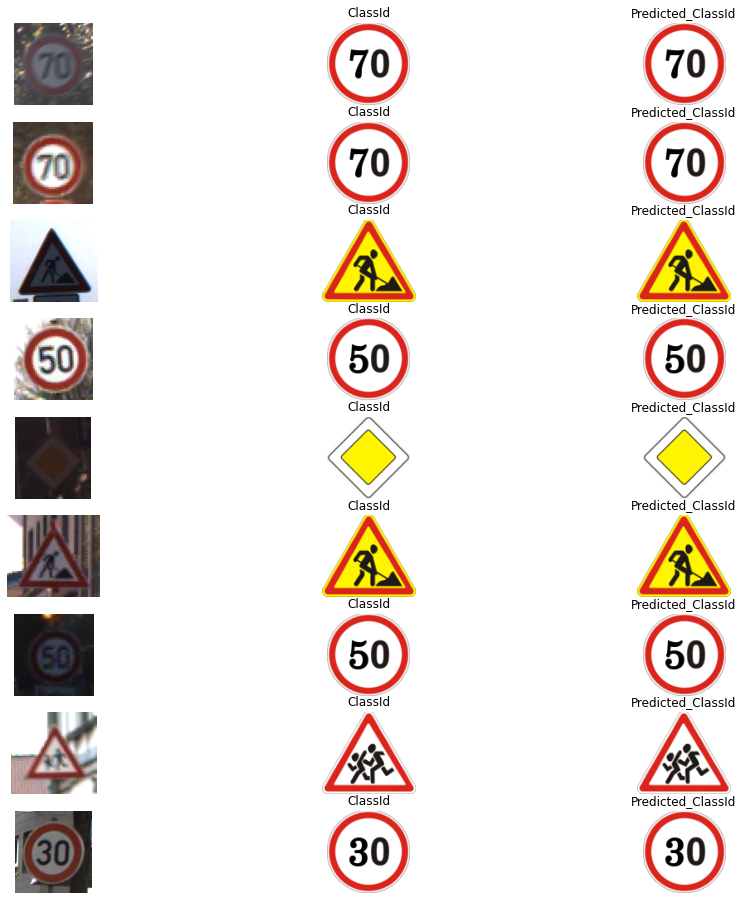

In [101]:
plt.figure(figsize=(16,16))
#plt.tight_layout()
class_id=correct_pred['ClassId']
pred=correct_pred['Predictions']

for i,j in enumerate(correct_pred['Path']):
    img=Image.open('C:/Users/pmals/Desktop/DSMLDLAI/German Traffic Sign Recognition/'+j)
    plt.subplot(9,3,3*i+1)
    plt.axis('off')
    plt.imshow(img)
    
for i,j in enumerate(class_id):
    img=Image.open('C:/Users/pmals/Desktop/DSMLDLAI/German Traffic Sign Recognition/Meta/'+str(j)+'.png')
    plt.subplot(9,3,3*i+2)
    plt.axis('off')
    plt.title('ClassId')
    plt.imshow(img)

for i,j in enumerate(pred):
    img=Image.open('C:/Users/pmals/Desktop/DSMLDLAI/German Traffic Sign Recognition/Meta/'+str(j)+'.png')
    plt.subplot(9,3,3*i+3)
    plt.axis('off')
    plt.title('Predicted_ClassId')
    plt.imshow(img) 